## Create a Gradient Boost Model model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor

#from sktime.forecasting import arima
%load_ext autoreload 
%autoreload 2

# import helper python files
import functions as fun
import grad_boost_help as gbf

In [2]:
dataset = pd.read_csv('target.csv')
features = pd.read_csv('features.csv')
features.head()

,Unnamed: 0,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
0,0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,...,1,0,0,0,0,0,-0.258819,0.965926,-0.000717,1.000000
1,1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,...,0,0,0,0,1,0,0.000000,1.000000,0.000000,1.000000
2,2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,...,0,0,0,0,1,0,0.258819,0.965926,0.000717,1.000000
3,3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,...,0,0,0,0,1,0,0.500000,0.866025,0.001435,0.999999
4,4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,...,0,0,0,0,1,0,0.707107,0.707107,0.002152,0.999998


In [3]:
features = features.sort_values(by='epoch_utc')

In [4]:
features = features.reset_index()
features = features.drop(columns=['index'])
features

,Unnamed: 0,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
0,0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.320,57054.0,61.0,4940.0,...,1,0,0,0,0,0,-0.258819,9.659258e-01,-0.000717,1.000000
1,1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.070,57400.0,60.0,5073.0,...,0,0,0,0,1,0,0.000000,1.000000e+00,0.000000,1.000000
2,2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.080,57275.0,20.0,4284.0,...,0,0,0,0,1,0,0.258819,9.659258e-01,0.000717,1.000000
3,3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.910,58024.0,3.0,4273.0,...,0,0,0,0,1,0,0.500000,8.660254e-01,0.001435,0.999999
4,4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.410,59301.0,0.0,4961.0,...,0,0,0,0,1,0,0.707107,7.071068e-01,0.002152,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36763,36763,1.678644e+09,2023-03-12 18:00:00+00:00,22514.75,4385.50,0.0,130.422,58176.0,0.0,2286.0,...,0,0,1,0,0,0,-1.000000,-1.836970e-16,0.938377,0.345612
36764,36764,1.678648e+09,2023-03-12 19:00:00+00:00,23578.00,4326.75,0.0,110.600,57478.0,0.0,2648.0,...,0,0,1,0,0,0,-0.965926,2.588190e-01,0.938625,0.344939
36765,36765,1.678651e+09,2023-03-12 20:00:00+00:00,24823.25,4386.00,0.0,100.600,56175.0,0.0,2591.0,...,0,0,1,0,0,0,-0.866025,5.000000e-01,0.938872,0.344266
36766,36766,1.678655e+09,2023-03-12 21:00:00+00:00,25471.50,4231.00,0.0,95.776,55808.0,0.0,3143.0,...,0,0,1,0,0,0,-0.707107,7.071068e-01,0.939119,0.343592


In [5]:
dataset.index = features.datetime_de
dataset['idx'] = features.index
features.index = dataset.index

In [6]:
dataset_2022 = dataset['2018-12-31 23:00:00+00:00' : '2022-12-31 23:00:00+00:00']
features_2022 = features['2018-12-31 23:00:00+00:00' : '2022-12-31 23:00:00+00:00']

In [7]:
date =pd.to_datetime(features.datetime_de)
date.head()

datetime_de
2018-12-31 23:00:00+00:00   2018-12-31 23:00:00+00:00
2019-01-01 00:00:00+00:00   2019-01-01 00:00:00+00:00
2019-01-01 01:00:00+00:00   2019-01-01 01:00:00+00:00
2019-01-01 02:00:00+00:00   2019-01-01 02:00:00+00:00
2019-01-01 03:00:00+00:00   2019-01-01 03:00:00+00:00
Name: datetime_de, dtype: datetime64[ns, UTC]

In [8]:
co2 = dataset_2022['emission_factor']
co2.index = dataset_2022.idx


In [9]:
co2

idx
0        298.240217
1        266.522473
2        262.594215
3        260.190772
4        250.496683
            ...    
35060    195.617034
35061    196.523798
35062    199.292403
35063    194.357142
35064    150.310416
Name: emission_factor, Length: 35065, dtype: float64

In [10]:
features_2022.index = co2.index
features = features_2022.drop(columns=['Unnamed: 0', 'datetime_de','epoch_utc'])

In [11]:
features

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
idx,,,,,,,,,,,,,,,,,,,,,
0,18879.75,5069.00,0.0,28.320,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1,0,0,0,0,0,-0.258819,0.965926,-0.000717,1.000000
1,20626.50,5042.25,0.0,10.070,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0,0,0,0,1,0,0.000000,1.000000,0.000000,1.000000
2,22355.50,5028.50,0.0,-4.080,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0,0,0,0,1,0,0.258819,0.965926,0.000717,1.000000
3,24032.50,4977.75,0.0,-9.910,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0,0,0,0,1,0,0.500000,0.866025,0.001435,0.999999
4,25452.00,4907.25,0.0,-7.410,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0,0,0,0,1,0,0.707107,0.707107,0.002152,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35060,35012.00,2960.25,0.0,1.322,63184.0,0.0,2532.0,0.0,254.0,0.0,...,0,1,0,0,0,0,-0.965926,0.258819,-0.003586,0.999994
35061,35091.50,2855.00,0.0,1.390,61885.0,0.0,2584.0,0.0,298.0,0.0,...,0,1,0,0,0,0,-0.866025,0.500000,-0.002869,0.999996
35062,34313.75,2897.75,0.0,0.920,59945.0,0.0,2608.0,0.0,311.0,0.0,...,0,1,0,0,0,0,-0.707107,0.707107,-0.002152,0.999998


## Creation of Gboost regressor 

### Train Test Split

In [12]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(co2)#
assert(n == len(features))

# split the target into train and test set
co2_train = co2[0:int(n*train_ratio)]
co2_train_val = co2[0:int(n*val_ratio)+3]
co2_val = co2[int(n*train_ratio):int(n*val_ratio)+3]
co2_test = co2[int(n*val_ratio)+3:]
date_test = date[int(n*val_ratio)+3:len(co2)]

# split the features into train and test set
features_train = features[0:int(n*train_ratio)]
features_train_val = features[0:int(n*val_ratio)+3]
features_val = features[int(n*train_ratio):int(n*val_ratio)+3]
features_test = features[int(n*val_ratio)+3:]

assert( len(co2_train) == len(features_train))
assert( len(co2_train_val) == len(features_train_val))
assert( len(co2_val) == len(features_val))
assert( len(co2_test) == len(features_test))

In [13]:
#get number of features
n_features = len(features.columns)
print(n_features)

32


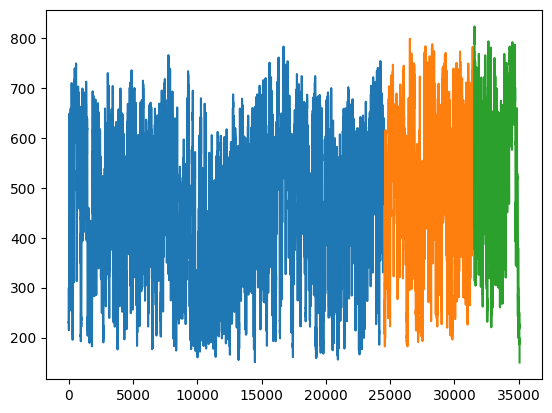

In [14]:
# check the train test split by plotting both

plt.plot(co2_train)
plt.plot(co2_val)
plt.plot(co2_test)
plt.show()

### Create walk forward split

In [15]:
n_val = co2_val.shape[0]
val_split = 8
val_len = n_val // val_split
assert( n_val % val_split == 0)
print('This is the length of the validation data set:', n_val)
print('This is the number of validation splits:', val_split)
print('This is the length of one validation split:', val_len)

This is the length of the validation data set: 7016
This is the number of validation splits: 8
This is the length of one validation split: 877


In [16]:
from sklearn.model_selection import TimeSeriesSplit
# get object that contains split indexes accorcing to the test lenght and the forecast period

#define forecast period
forecast_period = 24
tscv_val = TimeSeriesSplit(gap = 0, test_size= val_len, n_splits = val_split)
tscv_test = TimeSeriesSplit(gap = 0, test_size= forecast_period, n_splits = int(len(co2_test)/forecast_period))

In [17]:
for train_index, test_index in tscv_val.split(co2_train_val):
    print("TRAIN:", train_index, "VALIDATE:", test_index)
    X_train, X_test = features.values[train_index], features.values[test_index]
    y_train, y_test = co2.values[train_index], co2.values[test_index]

TRAIN: [    0     1     2 ... 24542 24543 24544] VALIDATE: [24545 24546 24547 24548 24549 24550 24551 24552 24553 24554 24555 24556
 24557 24558 24559 24560 24561 24562 24563 24564 24565 24566 24567 24568
 24569 24570 24571 24572 24573 24574 24575 24576 24577 24578 24579 24580
 24581 24582 24583 24584 24585 24586 24587 24588 24589 24590 24591 24592
 24593 24594 24595 24596 24597 24598 24599 24600 24601 24602 24603 24604
 24605 24606 24607 24608 24609 24610 24611 24612 24613 24614 24615 24616
 24617 24618 24619 24620 24621 24622 24623 24624 24625 24626 24627 24628
 24629 24630 24631 24632 24633 24634 24635 24636 24637 24638 24639 24640
 24641 24642 24643 24644 24645 24646 24647 24648 24649 24650 24651 24652
 24653 24654 24655 24656 24657 24658 24659 24660 24661 24662 24663 24664
 24665 24666 24667 24668 24669 24670 24671 24672 24673 24674 24675 24676
 24677 24678 24679 24680 24681 24682 24683 24684 24685 24686 24687 24688
 24689 24690 24691 24692 24693 24694 24695 24696 24697 24698 2469

In [18]:
co2_train_val.shape, co2_test.shape, co2.shape, co2_val.shape

((31561,), (3504,), (35065,), (7016,))

In [19]:
# check the number of splits for the forward validation
tscv_val.get_n_splits(), tscv_test.get_n_splits()

(8, 146)

In [20]:
# check if the tscv splits align with the test data set
assert(tscv_val.get_n_splits() == co2_val.shape[0] / val_len)
assert(tscv_test.get_n_splits() == co2_test.shape[0] / forecast_period)

### Walk forward manuel validating

In [21]:
alpha_low = 0.025
alpha_high = 0.975

In [22]:
common_params = dict(
    learning_rate=0.3,
    n_estimators= 350,
    #mean_sample_split = 8
    max_depth = 3,
    subsample = 1.0
)

In [23]:
all_models = {}
for alpha in [alpha_low, alpha_high]:
    all_models["q %1.3f" % alpha] = GradientBoostingRegressor(loss = "quantile", alpha=alpha,**common_params, random_state = 42)
all_models['mean'] = GradientBoostingRegressor(loss = "quantile",alpha=0.5,**common_params, random_state = 42)

In [24]:
print(all_models['q %1.3f' % alpha_low])
print(all_models['mean'])

GradientBoostingRegressor(alpha=0.025, learning_rate=0.3, loss='quantile',
                          n_estimators=350, random_state=42)
GradientBoostingRegressor(alpha=0.5, learning_rate=0.3, loss='quantile',
                          n_estimators=350, random_state=42)


In [25]:
features.columns

Index(['windon_forecast', 'windoff_forecast', 'solar_forecast',
       'prices_forecast', 'aggregated_generation_forecast', 'AT_import',
       'AT_export', 'CZ_import', 'CZ_export', 'DK_import', 'DK_export',
       'LU_import', 'LU_export', 'NL_import', 'NL_export', 'PL_import',
       'PL_export', 'CH_import', 'CH_export', 'co2_24_lag', 'co2_26_lag',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_sat',
       'day_of_week_sun', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'hour_of_day_sin', 'hour_of_day_cos',
       'hour_of_year_sin', 'hour_of_year_cos'],
      dtype='object')

## Walk forward testing

In [26]:
common_params = dict(
    learning_rate=0.3,
    n_estimators= 350,
    #mean_sample_split = 8
    max_depth = 3,
    subsample = 1.0,
)

In [27]:
all_models = {}
for alpha in [alpha_low, alpha_high]:
    all_models["q %1.3f" % alpha] = GradientBoostingRegressor(loss = "quantile", alpha=alpha,**common_params, random_state = 42)
all_models['mean'] = GradientBoostingRegressor(loss = "quantile", alpha = 0.5, **common_params, random_state = 42)

In [28]:
print(all_models)

{'q 0.025': GradientBoostingRegressor(alpha=0.025, learning_rate=0.3, loss='quantile',
                          n_estimators=350, random_state=42), 'q 0.975': GradientBoostingRegressor(alpha=0.975, learning_rate=0.3, loss='quantile',
                          n_estimators=350, random_state=42), 'mean': GradientBoostingRegressor(alpha=0.5, learning_rate=0.3, loss='quantile',
                          n_estimators=350, random_state=42)}


In [29]:
# define the confidence interval for the prediction
alpha_low = 0.025
alpha_high = 0.975
ci_width = alpha_high - alpha_low
print('width of confidence interval is:', ci_width)

width of confidence interval is: 0.95


In [30]:
pred_tet,report_test,lower_test,upper_test = gbf.walk_forward_gb(tscv_test, all_models, co2, features, co2_test, alpha_low, alpha_high, n_features, 'Gradient Boosting', refit = True)
print(report_test)

MAE for Gradient Boosting: 40.66 g_CO2/kWh
MAPE for Gradient Boosting: 8.17 %
RMSE for Gradient Boosting: 62.1 g_CO2/kWh
Pinball for lower Quantile Gradient Boosting: 5.05 g_CO2/kWh
Pinball for higher Quantile Gradient Boosting: 5.32 g_CO2/kWh
Interval Score Gradient Boosting: 165.1303 g_CO2/kWh
Real Values insisde PI Gradient Boosting: 84.47 %
R2 Gradient Boosting: 81.43 %
Adjusted R2 Gradient Boosting: 81.26 %


In [31]:
pred_test_df = pd.DataFrame(pred_tet)
pred_test_df.to_csv('best_gb_mean_wf_test3.csv')
pred_test_df.head() 

,0
0,686.562337
1,697.294188
2,711.222387
3,697.007073
4,699.877741


In [32]:
upper_test_df = pd.DataFrame(upper_test)
upper_test_df.to_csv('best_gb_upper_wf_test3.csv')
upper_test_df


,0
0,769.525582
1,756.939774
2,758.239609
3,772.005214
4,763.200477
...,...
3499,258.199609
3500,224.844654
3501,221.440057
3502,231.857350


In [33]:
lower_test_df = pd.DataFrame(lower_test)
lower_test_df.to_csv('best_gb_lower_wf_test3.csv')
lower_test_df

,0
0,488.585525
1,495.635540
2,508.459814
3,606.896532
4,616.855174
...,...
3499,186.498553
3500,149.367710
3501,171.696179
3502,153.189183


In [34]:
date_test

datetime_de
2022-08-08 00:00:00+00:00   2022-08-08 00:00:00+00:00
2022-08-08 01:00:00+00:00   2022-08-08 01:00:00+00:00
2022-08-08 02:00:00+00:00   2022-08-08 02:00:00+00:00
2022-08-08 03:00:00+00:00   2022-08-08 03:00:00+00:00
2022-08-08 04:00:00+00:00   2022-08-08 04:00:00+00:00
                                       ...           
2022-12-31 19:00:00+00:00   2022-12-31 19:00:00+00:00
2022-12-31 20:00:00+00:00   2022-12-31 20:00:00+00:00
2022-12-31 21:00:00+00:00   2022-12-31 21:00:00+00:00
2022-12-31 22:00:00+00:00   2022-12-31 22:00:00+00:00
2022-12-31 23:00:00+00:00   2022-12-31 23:00:00+00:00
Name: datetime_de, Length: 3504, dtype: datetime64[ns, UTC]

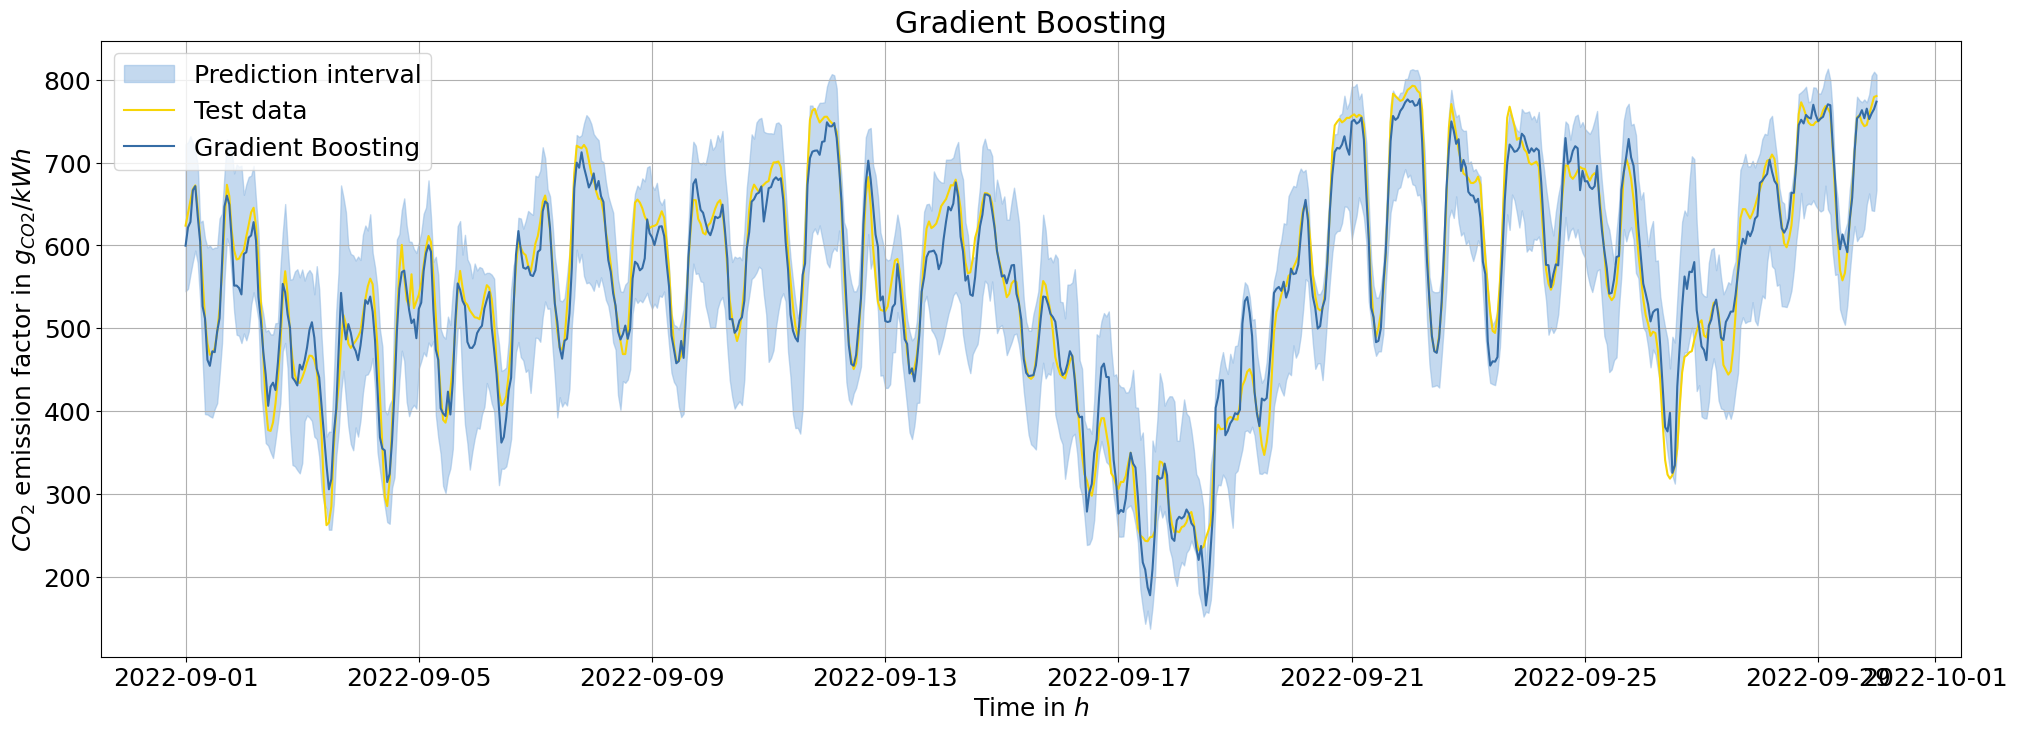

In [40]:
fun.plot_model_uncertainty(co2_test, pred_test_df, lower_test_df ,upper_test_df, date_test, slice_start = '2022-09-01 00:00', slice_end =  '2022-09-30 00:00', method = 'Gradient Boosting')

In [ ]:
import joblib

In [ ]:
joblib.dump(all_models, 'grad_boost_models.pkl')

['grad_boost_models.pkl']

In [ ]:
co2_test

idx
31561    788.355006
31562    804.205081
31563    818.553923
31564    822.653306
31565    804.489009
            ...    
35060    195.617034
35061    196.523798
35062    199.292403
35063    194.357142
35064    150.310416
Name: emission_factor, Length: 3504, dtype: float64

C:\Users\abajrami\AppData\Local\Temp\ipykernel_51432\3188447347.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(co2_test[:1000])


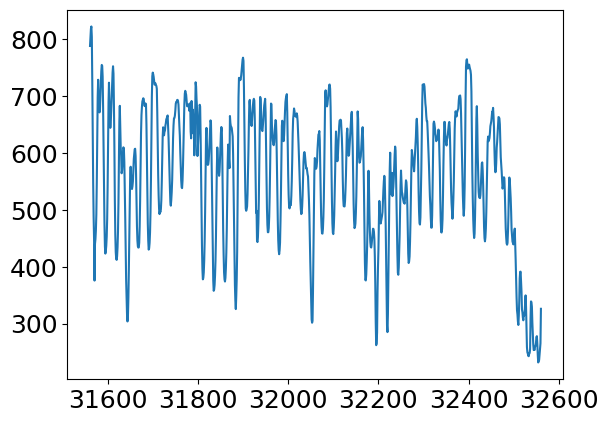

In [ ]:
plt.plot(co2_test[:1000])

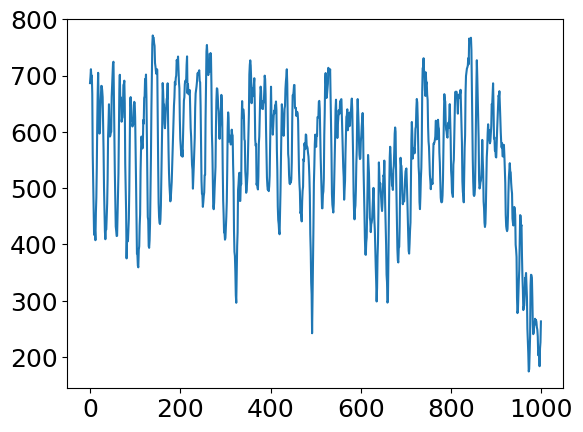

In [ ]:
plt.plot(pred_test_df[:1000])